# Machine Learning - Citi Bank

I will be using this data set to illustrate different predictive analytic methods. The point of this analysis will be to showcase the use of pyspark pipelines and various classification modes and some of thier outputs

This will be important or helpful for any predictive analysis you will have to do. The pipe lets you work with big data easier and pyspark is significantly faster when it comes to processing speed

In [1]:
#library used
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import rand,when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator    
import pyspark.sql.functions as func
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
import pyspark.ml.evaluation as ev
import matplotlib.pyplot as plt

In [2]:
#connecting spark and calling the data
spark = SparkSession.builder.master('local[2]').config("spark.executor.memory","1g").config("spark.drive.memory","1g").appName('spark_sh_data').getOrCreate()
df = spark.read.options(header=None, nullValue='NULL', inferSchema=True).option('nullValue','null').csv('bikeClean2.csv')
df.head()

Row(_c0='tripduration', _c1='starttime', _c2='stoptime', _c3='start station id', _c4='start station name', _c5='start station latitude', _c6='start station longitude', _c7='end station id', _c8='end station name', _c9='end station latitude', _c10='end station longitude', _c11='bikeid', _c12='usertype', _c13='birth year', _c14='gender', _c15='subscriber', _c16='day_of_week', _c17='weekend', _c18='duration_minutes')

In [3]:
#drop not needed columns
dfnew = df.drop(*['_c4', '_c8', '_c12'])

In [4]:
#change columns to int so can perform predicitons and easier for pipe
newDf1 = dfnew.withColumn('_c0', df["_c0"].cast(IntegerType())).withColumn('_c1', df["_c1"].cast(IntegerType())).withColumn('_c2', df["_c2"].cast(IntegerType()))\
        .withColumn('_c3', df["_c3"].cast(IntegerType())).withColumn('_c5', df["_c5"].cast(IntegerType()))\
        .withColumn('_c6', df["_c6"].cast(IntegerType())).withColumn('_c7', df["_c7"].cast(IntegerType()))\
        .withColumn('_c9', df["_c9"].cast(IntegerType())).withColumn('_c10', df["_c10"].cast(IntegerType()))\
        .withColumn('_c11', df["_c11"].cast(IntegerType())).withColumn('_c13', df["_c13"].cast(IntegerType()))\
        .withColumn('_c14', df["_c14"].cast(IntegerType())).withColumn('_c15', df["_c15"].cast(IntegerType()))\
        .withColumn('_c17', df["_c17"].cast(IntegerType())).withColumn('_c18', df["_c18"].cast(IntegerType()))

In [5]:
#check schema
newDf1.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: integer (nullable = true)
 |-- _c3: integer (nullable = true)
 |-- _c5: integer (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: integer (nullable = true)
 |-- _c9: integer (nullable = true)
 |-- _c10: integer (nullable = true)
 |-- _c11: integer (nullable = true)
 |-- _c13: integer (nullable = true)
 |-- _c14: integer (nullable = true)
 |-- _c15: integer (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: integer (nullable = true)
 |-- _c18: integer (nullable = true)



In [6]:
newDf1.show()

+----+----+----+----+----+----+----+----+----+-----+----+----+----+-----------+----+----+
| _c0| _c1| _c2| _c3| _c5| _c6| _c7| _c9|_c10| _c11|_c13|_c14|_c15|       _c16|_c17|_c18|
+----+----+----+----+----+----+----+----+----+-----+----+----+----+-----------+----+----+
|null|null|null|null|null|null|null|null|null| null|null|null|null|day_of_week|null|null|
| 897|   1|   1| 493|  40| -73| 454|  40| -73|18340|1966|   1|   2|     Monday|   0|  14|
| 267|   1|   1|3143|  40| -73|3226|  40| -73|21458|1996|   1|   1|     Monday|   0|   4|
|2201|   1|   1| 317|  40| -73|3469|  40| -73|39874|1986|   1|   2|     Monday|   0|  36|
|1660|   1|   1| 249|  40| -74| 369|  40| -74|38865|1988|   1|   2|     Monday|   0|  27|
| 109|   1|   1|3552|  40| -73|3538|  40| -73|30256|1997|   1|   2|     Monday|   0|   1|
| 106|   1|   1|3593|  40| -73|3592|  40| -73|16875|1988|   1|   2|     Monday|   0|   1|
| 550|   1|   1|3507|  40| -73|3553|  40| -73|34139|1992|   1|   2|     Monday|   0|   9|
| 338|   1

In [7]:
#convert your string to int
stringIndexer = StringIndexer().setInputCol("_c16").setOutputCol("_c16_index").setHandleInvalid("skip")
_16_index_model=stringIndexer.fit(newDf1)
_16_index_df=_16_index_model.transform(newDf1)

In [8]:
#use the one hot encoder on that stringindexer
encoder = OneHotEncoder().setInputCols(["_c16_index"]).setOutputCols(["_16_encoded"])
encoder_model=encoder.fit(_16_index_df)
encoder_df=encoder_model.transform(_16_index_df)



In [9]:
#assemble the rest of columns
assembler = VectorAssembler().setInputCols(['_c0','_c1','_c2','_c3','_c5','_c6','_c7','_c9',
                                            '_c10','_c11','_c13','_c14','_c17','_c18'])\
                    .setOutputCol("vectorized_features")\
                        .setHandleInvalid("skip")
                                  
assembler_df = assembler.transform(encoder_df)

In [11]:
#for your response variable
label_indexer = StringIndexer().setInputCol("_c15").setOutputCol("label")

label_indexer_model=label_indexer.fit(assembler_df)
label_indexer_df = label_indexer_model.transform(assembler_df)

In [13]:
#always scale your model
scaler = StandardScaler().setInputCol("vectorized_features").setOutputCol("features")
scaler_model=scaler.fit(label_indexer_df)
scaler_df = scaler_model.transform(label_indexer_df)
pd.set_option('display.max_colwidth', 100)

In [14]:
#put it all in a pipe
pipeline_stages=Pipeline().setStages([stringIndexer,encoder,assembler,label_indexer,scaler])

pipeline_model=pipeline_stages.fit(newDf1)
pipeline_df=pipeline_model.transform(newDf1)

# Analysis 

After you fit you pipe now you can begin your analysis. The pipe is also interesting because you could send that piped model to anyone you want with a pickle allowing them to access that large data set


In [15]:
#train model
train, test = pipeline_df.randomSplit([0.8,0.2], seed=56)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1745133
Test Dataset Count: 435877


In [16]:
#logisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
lr_summary=lrModel.summary

These are all methods of evaluating the model

In [17]:
lr_summary.areaUnderROC

0.7093301779037383

In [18]:
lr_summary.accuracy

0.8649357957244519

In [19]:
lr_summary.precisionByLabel

[0.8636634276746995, 0.8895521691986615]

These are visual representation to evaluate the model

In [20]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

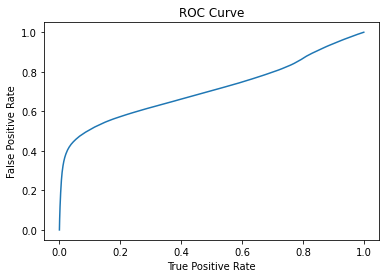

Training set areaUnderROC: 0.7093301779037383


In [21]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Other ways to evalute accuracy of your model

In [23]:
#Evaluate our Logistic Regression model.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
predictions = lrModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.70777726934561


In [24]:
#you can check your predictions
predictions.select('label','rawPrediction','probability','prediction').toPandas().head(5)


label                              rawPrediction  \
0    0.0  [1.6449381313946918, -1.6449381313946918]   
1    0.0  [1.8621994191595799, -1.8621994191595799]   
2    0.0  [2.4427193225463792, -2.4427193225463792]   
3    1.0  [-0.0151081397858579, 0.0151081397858579]   
4    0.0  [1.6164169816927116, -1.6164169816927116]   

                                 probability  prediction  
0   [0.8382057503093875, 0.1617942496906125]         0.0  
1   [0.8655531023455828, 0.1344468976544172]         0.0  
2  [0.9200273960522601, 0.07997260394773986]         0.0  
3   [0.4962230368961011, 0.5037769631038989]         1.0  
4   [0.8343003948531139, 0.1656996051468861]         0.0

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol='label',metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(predictions))

R Squared (R2) on test data = 0.0574956


In [26]:
from sklearn.metrics import confusion_matrix

y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[358059,   2351],
       [ 56462,  19005]])

# TakeAway

By the end of this you should be able to

    1) Follow the steps to pipe your model with pyspark
    
    
    2) Be able to evaluate a model with logistic regression as well as create some models
    